In [67]:
#!pip install fontawesomefree

# Then reinstall pywaffle
#!pip install --force-reinstall --no-deps pywaffle

import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import folium
import geopandas
import matplotlib.pyplot as plt
from IPython.display import display
from pywaffle import Waffle
import numpy as np

In [68]:
schools_accr = pd.read_csv('richmond_schools_accredit.csv')

In [69]:
evic_zipcode = pd.read_csv('richmond_evic_zipcode_2022.csv')

In [70]:
evic_zip_rate = pd.read_csv('union.csv')

In [71]:
schools_accr.drop(schools_accr.index[schools_accr['school_type'] == 'Combined 6-12'], inplace=True)
schools_accr.drop(schools_accr.index[schools_accr['school_type'] == 'Combined K-12'], inplace=True)

In [72]:
schools_accr['zip'] = schools_accr['address'].str.extract(r'(\d{5}\-?\d{0,4})')

In [73]:
schools_accr['zip'] = schools_accr['zip'].apply(lambda x: x[0:5])


In [74]:
#change zipcode to str in evic_rate dataframe
evic_zip_rate.Id = evic_zip_rate.Id.astype(str)
evic_zip_rate['Id'] = evic_zip_rate['Id'].apply(lambda x: x[0:-2])
evic_zip_rate.rename(columns = {'Id':'zip'}, inplace = True)

In [75]:
type(schools_accr['zip'][1])

str

In [76]:
evic_ed = pd.merge(schools_accr, evic_zip_rate, on = 'zip', how='inner')

In [77]:
evic_ed.to_csv('evic_ed.csv')


In [78]:
evic_ed['nonwhite'] = 100-evic_ed['white']

In [79]:
evic_ed['school_type'] = evic_ed['school_type'].map({'Elementary': 'Elementary Schools', 'Middle': 'Middle Schools','High':'High Schools'})


In [80]:
evic_ed['accred'] = evic_ed['accred'].map({'Accredited': 'Fully Accredited', 'Accredited with Conditions':'Accredited with Conditions'})


In [81]:
dropped_nulls = schools_accr.dropna(subset = ['eng_ach_gap'], how='any',axis=0) 
dropped_nulls.head()

,school,accred,school_type,address,latitude,longitude,eng_acad_ach,math_acad_ach,sci_acad_ach,eng_ach_gap,...,grad_rate,econ_disadv,disabilities,black,hispanic,white,eng_learners,grad_rate.1,dropout_rate.1,zip
0,Barack Obama Elementary,Accredited,Elementary,"3101 Fendall Ave Richmond, VA 23222-2699",37.57376,-77.43577,1,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23222
1,Bellevue Elementary,Accredited with Conditions,Elementary,"2301 E Grace St Richmond, VA 23223-7151",37.53117,-77.42140,1,2,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23223
2,Blackwell Elementary,Accredited with Conditions,Elementary,"1600 Everett St Richmond, VA 23224-3896",37.51555,-77.44500,3,3,3.0,3.0,...,NaN,85.5,12.7,85.5,9.7,1.8,NaN,NaN,NaN,23224
3,Broad Rock Elementary,Accredited,Elementary,"4615 Ferguson Ln Richmond, VA 23234-1999",37.47639,-77.47869,1,1,3.0,1.0,...,NaN,74.4,10.1,46.2,50.0,2.4,NaN,NaN,NaN,23234
4,Cardinal Elementary,Accredited with Conditions,Elementary,"1745 Catalina Dr Richmond, VA 23224-4899",37.49033,-77.47651,1,1,3.0,1.0,...,NaN,53.8,5.5,13.2,84.2,1.6,NaN,NaN,NaN,23224


In [82]:
accred_dicot = []
count = 0
for i in dropped_nulls['accred']:
    if i == 'Accredited':
        accred_dicot.append(0)
    elif i == 'Accredited with Conditions':
        accred_dicot.append(.5)
    else:
        accred_dicot.append(1)
dropped_nulls['accred_dicot'] = accred_dicot

<ipython-input-82-10a1d10626c2>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
eng_dim = go.parcats.Dimension(
    values = dropped_nulls['eng_ach_gap'],
    label = 'English Achievement Gap',
    categoryorder = 'array',
    categoryarray = ['1','2','3'],
    ticktext = ['Level<br>One', 'Level<br>Two', 'Level<br>Three'],
)


math_dim = go.parcats.Dimension(
    values = dropped_nulls['math_ach_gap'],
    label=  'Math Achievement Gap',
    categoryorder = 'array',
    categoryarray = ['1','2','3'],
    ticktext = ['Level<br>One', 'Level<br>Two', 'Level<br>Three'],
)

abs_dim = go.parcats.Dimension(
    values = dropped_nulls['chro_abs'],
    label=  'Chronic Absenteeism',
    categoryorder = 'array',
    categoryarray = ['1','2','3'],
    ticktext = ['Level<br>One', 'Level<br>Two', 'Level<br>Three'],
)

accred_dim = go.parcats.Dimension(
    values = dropped_nulls['accred'],
    label= 'Accreditation',
    categoryorder = 'array',
    categoryarray = ['Accredited', 'Accredited with Conditions'],
    ticktext = ['Accredited', 'Accredited<br>with Conditions']
)

school_dim = go.parcats.Dimension(
    values = dropped_nulls['school_type'],
    label = 'School Level'
)

color = dropped_nulls.accred_dicot
colorscale = [[0, 'gray'], [.5, 'royalblue'], [1, 'rgb(203,76,78)']]
    
fig = go.Figure(data = [go.Parcats(dimensions=[accred_dim, eng_dim, math_dim, abs_dim, school_dim],
                                  hoverinfo = 'count',
                                  line = {'color':color, 'colorscale':colorscale, 'shape':'hspline'},
                                  labelfont = {'size':16, 'family': 'Arial'},
                                  tickfont = {'size':12, 'family': 'Arial'},
                                  )])

fig.update_layout(height = 700, width = 1000,
                           title_text = 'Richmond Schools Accreditation',
                           title_x = 0.5
                           )

fig.show()
fig.write_image('school_cat.png')
fig.write_html('school_cat.html')


In [84]:
ticktext = ['']
fig = px.strip(evic_ed, x='econ_disadv', y='school_type',
              color = 'accred',
              labels = {'accred':'Accreditation Status','econ_disadv':'% Economically Disadvantaged Students',
                        'school_type':'', 'Accredited':'Fully Accredited'},
              color_discrete_sequence = ['gray','red'],
              category_orders = {'school_type':['Elementary Schools', 'Middle Schools', 'High Schools']},
              orientation = 'v',
              stripmode = 'overlay',
              range_x = [0,100],
              height = 500,
              hover_data = {'accred':False, 'econ_disadv':':.0f%', 'school_type':False,
                            'Month Rate':':.0f%'},
              custom_data = ['school', 'Month Rate']
              )

customdata = np.stack((evic_ed['school'], evic_ed['Month Rate']), axis=-1)

fig.update_traces(marker={'size': 14, 'opacity':0.5})

fig.update_traces(hovertemplate=('%{customdata[0]}<br>'+'Economically Disadvantaged Students: %{x:.1f}%<br>'+'Eviction Rate in Zipcode: %{customdata[1]}'),
                        hoverlabel=dict(
                        bgcolor = 'lightgray',
                        font_size=16,
                        ))

fig.update_layout(hovermode="x unified", plot_bgcolor = 'white')
fig.update_yaxes(showgrid=True, gridwidth=2, gridcolor='lightgray')



fig.show()
fig.write_html('econ_disadv_strip.html')
fig.write_image('econ_disadv_strip.png')


In [85]:
fig = px.strip(evic_ed, x='black', y='school_type',
              color = 'accred',
              labels = {'accred':'Accreditation Status','econ_disadv':'% Economically Disadvantaged Students',
                        'school_type':'', 'Accredited':'Fully Accredited'},
              hover_data = {'accred':False, 'black':':.0f%', 'school_type':False},
              hover_name = 'school',
              category_orders = {'school_type':['Elementary Schools', 'Middle Schools', 'High Schools']},
              orientation = 'v',
              stripmode = 'group',
              range_x = [0,100],
              height = 500,
              custom_data = ['school', 'Month Rate'],
              color_discrete_sequence = ['gray','red'],

               
              )
fig.update_traces(marker={'size': 14, 'opacity':0.5})

fig.update_traces(hovertemplate=('%{customdata[0]}<br>'+'Black Students: %{x:.1f}%<br>'+'Eviction Rate in Zipcode: %{customdata[1]}'),
                        hoverlabel=dict(
                        bgcolor = 'lightgray',
                        font_size=16,
                        ))

fig.update_layout(hovermode="x unified", plot_bgcolor = 'white')
fig.update_yaxes(showgrid=True, gridwidth=2, gridcolor='lightgray')
fig.write_html('afr_am_strip.html')
fig.write_image('afr_am_strip.png')

fig.show()

In [86]:
fig = px.strip(evic_ed, x='nonwhite', y='school_type',
              color = 'accred',
              labels = {'accred':'Accreditation Status','econ_disadv':'% Economically Disadvantaged Students',
                        'school_type':'', 'Accredited':'Fully Accredited', 'nonwhite':'% Non-white Students'},
              hover_data = {'accred':False, 'black':':.0f%', 'school_type':False},
              hover_name = 'school',
              category_orders = {'school_type':['Elementary', 'Middle', 'High']},
              orientation = 'v',
              range_x = [0,110],
              height = 500,
              custom_data = ['school', 'Month Rate'],
              color_discrete_sequence = ['gray','red'],

               
              )
fig.update_traces(marker={'size': 14, 'opacity':0.5})

fig.update_traces(hovertemplate=('%{customdata[0]}<br>'+'Non-white Students: %{x:.1f}%<br>'+'Eviction Rate in Zipcode: %{customdata[1]}'),
                        hoverlabel=dict(
                        bgcolor = 'lightgray',
                        font_size=16,
                        ))
fig.update_traces(jitter=1)

fig.update_layout(hovermode="x unified", plot_bgcolor = 'white')
fig.update_yaxes(showgrid=True, gridwidth=2, gridcolor='lightgray')

fig.write_html('non_white_strip.html')
fig.write_image('non_white_strip.png')

fig.show()

In [87]:
fig = px.scatter(evic_ed, x='black', y='econ_disadv',
                 hover_name='school', 
                 color = 'accred',
                 labels = {'accred':'Accreditation','black':'% Black Students', 'econ_disadv':'% Economically Disadvantaged Students'},
                 hover_data = {'accred':False},
                 height = 600)
fig.update_traces(marker={'size': 12, 'opacity':0.7})
#fig.update_traces(marker = {'symbol': 'hexagon'},
 #                selector = {'schooL_type':'Elementary'})

fig.write_image('scatter.png')
fig.write_html('scatter.html')
fig.show()

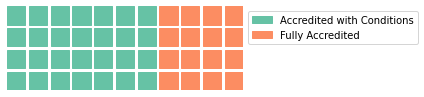

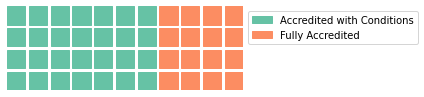

In [88]:
waffle = plt.figure(
    FigureClass=Waffle,
    rows=4,
    columns=11,
    values=schools_accr['accred'].value_counts(),
    legend={
        'labels': ['Accredited with Conditions', 'Fully Accredited'], 
        'loc': 'upper left', 
        'bbox_to_anchor': (1, 1)},
    icon_size=20,
    icon_style=['regular', 'solid'],

)
waffle